In [1]:
import pandas as pd 
import numpy as np
import matplotlib.pyplot as plt
from pylab import mpl
mpl.rcParams['font.sans-serif']=['SimHei']
from sklearn.model_selection import train_test_split


In [2]:
#任务1.1 文件读取
info=pd.read_csv('meal_order_info.csv',encoding='GBK')
detail=pd.read_csv('meal_order_detail.csv')

In [3]:
#任务1.2 去掉特殊的字符
newdishname=[]
for i in detail.dishes_name.tolist():
    if '/n' or '/r' in i:
        a=i.replace('\n','').replace('\r','')
        newdishname.append(a)
detail.dishes_name=newdishname

In [4]:
#任务1.3 构建热度函数
def hot_rating(data):
    return (data-data.min())/(data.max()-data.min())


2016年8月销量为：463704


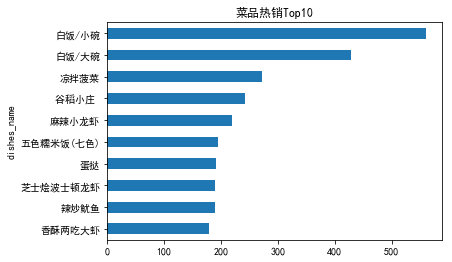

In [5]:
#任务1.4 画图
data=detail[['dishes_name','counts','amounts']]
data.groupby('dishes_name').sum().sort_values(by='counts').tail(10)['counts'].plot.barh(title="菜品热销Top10")
print("2016年8月销量为："+str(sum(data.counts*data.amounts)))

In [6]:
#任务2.1 订单状态占比
info.order_status.value_counts(normalize=True)

1    0.987302
0    0.009524
2    0.003175
Name: order_status, dtype: float64

In [7]:
#任务2.2 选取有效的订单数据
info=info[info.order_status==1]
info=info.drop(['mode','cashier_id','pc_id','order_number','print_doc_bill_num','lock_table_info','check_closed'],axis=1)
detail=detail.drop(['logicprn_name','parent_class_name','cost','discount_amt','discount_reason','kick_back','add_info','bar_code'],axis=1)
detail=detail.drop(index=(detail.loc[(detail['dishes_name']=='白饭/小碗')].index))
detail=detail.drop(index=(detail.loc[(detail['dishes_name']=='白饭/大碗')].index))

In [8]:
#任务2.3 选取主要特征
data2=detail[['dishes_name','emp_id']]

In [9]:
#任务3.1 划分测试集与训练集
data2.emp_id.value_counts()
dish_order=data2.drop_duplicates()
#三个菜以上的顾客名单
customer_list=dish_order.emp_id.value_counts()[dish_order.emp_id.value_counts()>3].index.tolist()
#获取所有菜品名称
dishes_name=list(set(detail.dishes_name))
#按照顾客名单划分测试集与训练集
train_data,test_data=train_test_split(customer_list,test_size=0.3)

In [10]:
#3.2 二维矩阵---函数
def two_dimension(customer_list,dishes_list,df):
    customer_dish=pd.DataFrame(index=customer_list,columns=dishes_list)
    for i in customer_list:
        for j in df[df.emp_id==i].dishes_name.tolist():
            customer_dish.loc[i,j]=1
    customer_dish=customer_dish.fillna(0)
    return customer_dish
    

In [11]:
train_customer_dish=two_dimension(train_data,dishes_name,dish_order)
test_customer_dish=two_dimension(test_data,dishes_name,dish_order)

In [32]:
#任务4 模型构建
class ItemCF:
    def __init__(self,train_TwoMatrix,test_TwoMatrix):
        print('-----------模型实例化-----------')
        self.train_TwoMatrix=train_TwoMatrix
        self.test_TwoMatrix=test_TwoMatrix
        self.train_customerID=self.train_TwoMatrix.index.tolist()
        self.test_customerID=self.test_TwoMatrix.index.tolist()
        self.dish=train_TwoMatrix.columns.tolist()
        print('----------生成相似度矩阵---------')
        self.sim_all()
        print('---------相似度矩阵生成完毕-------')
        print('---------生成全顾客推荐列表-------')
        self.all_customer_recommodation_list()
        print('----------全顾客推荐列表生成完毕---------')
    #4.1 相似度
    #欧几里得距离
    def sim_two(self,dish1:list,dish2:list):
        return 1/(1+np.sqrt(((np.array(dish1)-np.array(dish2))**2).sum()))
    def sim_all(self):
        self.sim_matrix=pd.DataFrame(columns=self.dish,index=self.dish)
        for i in range(len(self.sim_matrix.columns)):
            for j in range(len(self.sim_matrix.columns)):
                self.sim_matrix.iloc[i,j]=self.sim_two(self.train_TwoMatrix.iloc[:,i].tolist(),self.train_TwoMatrix.iloc[:,j].tolist())
        return self.sim_matrix
    
    #4.2 生成推荐键对列表
    def recommodation_dic(self,customerName,df):   
        Name_rec_dic={}
        for i in self.dish:
            sim=0
            for j in self.dish:
                sim+=self.sim_matrix.loc[i,j]*df.loc[customerName,j]
            Name_rec_dic[i]=sim
        Name_rec_dic=sorted(Name_rec_dic.items(),key=lambda kv:(kv[1],kv[0]),reverse=True)
        return Name_rec_dic
    
    #生成全顾客推荐字典
    def all_customer_recommodation_list(self):
        self.train_all_dic={}
        self.test_all_dic={}
        for i in self.train_customerID:
            self.train_all_dic[i]=list(dict(self.recommodation_dic(i,self.train_TwoMatrix)))
        for i in self.test_customerID:
            self.test_all_dic[i]=list(dict(self.recommodation_dic(i,self.test_TwoMatrix)))
        return self.test_all_dic
    #生成指定个数的推荐菜品字典
    def select_recommodation_dic(self,n=10):
        self.select_dic={}
        for i in self.test_all_dic.keys():
            self.select_dic[i]=self.test_all_dic[i][0:n]
        return self.select_dic

In [33]:
#模型实例化
model=ItemCF(train_customer_dish,test_customer_dish)


-----------模型实例化-----------
----------生成相似度矩阵---------
---------相似度矩阵生成完毕-------
---------生成全顾客推荐列表-------
----------全顾客推荐列表生成完毕---------


In [27]:
#5.1构建客户IP字典
customerIP={}
for i in test_customer_dish.index.tolist():
    customerIP[i]=list(test_customer_dish.loc[i,:][test_customer_dish.loc[i,:]==1].index.tolist())


In [34]:
#5.2模型评价

def precise(test_predict_dic,dic):
    all_num=0
    precise=0
    total=0
    for i in list(test_predict_dic.keys()):
        total+=len(test_predict_dic[i])
        for j in test_predict_dic[i]:
            if j in dic[i]:
                precise+=1
    for i in list(dic.keys()):
        all_num+=len(dic[i])
    print('-------------模型效果分析---------------')
    print('客户总喜好个数为',all_num)
    print('总推荐个数为',total)
    print('准确预测的个数为',precise)
    print('预测准确率为',precise/total)
    print('召回率',precise/all_num)
    return precise/total,precise/all_num

In [35]:
pre=[]
rec=[]
for i in range(1,100):
    a,b=precise(model.select_recommodation_dic(i),customerIP)
    pre.append(a)
    rec.append(b)

-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 137
准确预测的个数为 137
预测准确率为 1.0
召回率 0.0543004359889021
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 274
准确预测的个数为 274
预测准确率为 1.0
召回率 0.1086008719778042
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 411
准确预测的个数为 411
预测准确率为 1.0
召回率 0.1629013079667063
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 548
准确预测的个数为 548
预测准确率为 1.0
召回率 0.2172017439556084
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 685
准确预测的个数为 681
预测准确率为 0.9941605839416059
召回率 0.2699167657550535
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 822
准确预测的个数为 802
预测准确率为 0.975669099756691
召回率 0.31787554498612763
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 959
准确预测的个数为 917
预测准确率为 0.9562043795620438
召回率 0.3634562029330162
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 1096
准确预测的个数为 1025
预测准确率为 0.9352189781021898
召回率 0.40626238604835513
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 1233
准确预测的个数为 1130
预测准确率为

-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 9864
准确预测的个数为 2325
预测准确率为 0.23570559610705596
召回率 0.9215219976218787
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10001
准确预测的个数为 2331
预测准确率为 0.23307669233076692
召回率 0.9239001189060642
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10138
准确预测的个数为 2336
预测准确率为 0.23042020122312093
召回率 0.9258818866428854
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10275
准确预测的个数为 2340
预测准确率为 0.22773722627737225
召回率 0.9274673008323424
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10412
准确预测的个数为 2344
预测准确率为 0.22512485593545908
召回率 0.9290527150217994
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10549
准确预测的个数为 2350
预测准确率为 0.22276993079912788
召回率 0.9314308363059849
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10686
准确预测的个数为 2359
预测准确率为 0.2207561295152536
召回率 0.9349980182322631
-------------模型效果分析---------------
客户总喜好个数为 2523
总推荐个数为 10823
准确预测的个数为 2364
预测准确率为 0.2184237272475284
召回率 0.936979785969

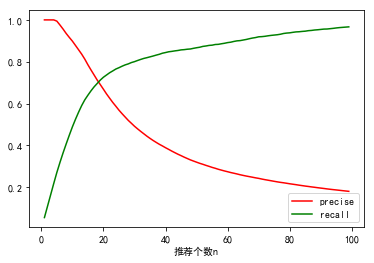

In [17]:
x=list(range(1,100))
plt.plot(x,pre,color='red')
plt.plot(x,rec,color='green')
plt.legend(['precise','recall'])
plt.xlabel('推荐个数n')
plt.savefig('模型评估.png')
plt.show()


In [36]:
pd.DataFrame(model.test_all_dic).to_excel('测试集推荐列表.xlsx')
pd.DataFrame(model.train_all_dic).to_excel('训练集推荐列表.xlsx')